In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
work = '/work/08811/aew492/ls6/small-scale_cross-corrs'
scratch = '/scratch/08811/aew492/small-scale_cross-corrs'

In [3]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from astropy.table import Table
import astropy.units as u
import astropy.cosmology.units as cu
import os
import sys
sys.path.insert(0, work)
from illustris_sim import IllustrisSim
import corrfunc_ls
import tools

#### load in data sets

In [5]:
z = 0.
# initialize simulation and snapshot
sim = IllustrisSim('TNG300-3', redshift=z)

In [6]:
# dark matter -> underlying density field
sim.load_dm_pos()
dm_subsample = tools.get_subsample(sim.dm_pos, nx=100).value

subsampling 2441406 random particles...


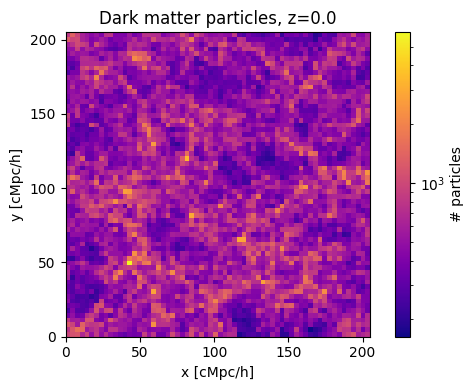

In [7]:
fig, ax = plt.subplots(figsize=(5.5,4))
_, _, _, im = ax.hist2d(dm_subsample[:,0], dm_subsample[:,1], cmap='plasma', norm=mpl.colors.LogNorm(), bins=64)
ax.set_xlim([0,205])
ax.set_ylim([0,205])
ticks = np.linspace(0, 200, 5)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_aspect('equal')
ax.set_xlabel('x [cMpc/h]')
ax.set_ylabel('y [cMpc/h]')
fig.colorbar(im, ax=ax, label='# particles')
ax.set_title(f'Dark matter particles, z={z}')
fig.tight_layout()

In [8]:
# galaxies -> tracers
galaxies = get_LRG_galaxies(sim)

In [9]:
gal_pos = (galaxies['SubhaloPos']*u.kpc).to(u.Mpc)

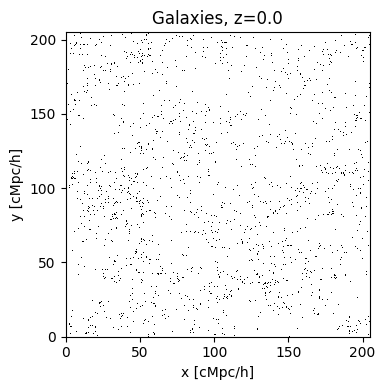

In [10]:
fig, ax = plt.subplots(figsize=(5.5,4))
ax.plot(gal_pos[:,0].value, gal_pos[:,1].value, ls='None', marker=',', color='k')
ax.set_xlim([0,205])
ax.set_ylim([0,205])
ticks = np.linspace(0, 200, 5)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_aspect('equal')
ax.set_xlabel('x [cMpc/h]')
ax.set_ylabel('y [cMpc/h]')
ax.set_title(f'Galaxies, z={z}')
fig.tight_layout()

#### DM x Gal cross-correlation

In [11]:
# parameters
randmult = 3
rmin = 1.
rmax = 75.
nbins = 20
nthreads = 12

In [12]:
ravg, xi_galxdm = corrfunc_ls.compute_3D_ls_cross(dm_subsample, gal_pos.value, randmult, rmin, rmax, nbins,
                                                    logbins=True, periodic=True, prints=True)

D1D2 calculated
D1R calculated
D2R calculated
RR calculated
3d counts converted to cf


Text(0.5, 1.0, '2-pt. Gal x DM (TNG300-3, z=0.00)')

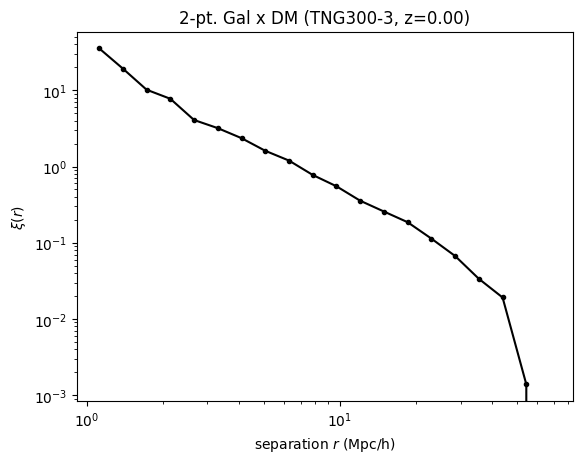

In [13]:
fig, ax = plt.subplots()

ax.plot(ravg, xi_galxdm, 'k.-')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'separation $r$ (Mpc/h)')
ax.set_ylabel(r'$\xi(r)$')
ax.set_title(f'2-pt. Gal x DM ({sim.sim_tag})')

#### galaxy autocorrelation

In [14]:
ravg, xi_galxgal = corrfunc_ls.compute_3D_ls_auto(gal_pos.value, randmult, rmin, rmax, nbins,
                                                  logbins=True, periodic=True)

Text(0.5, 1.0, '2-pt. Gal x Gal (TNG300-3, z=0.00)')

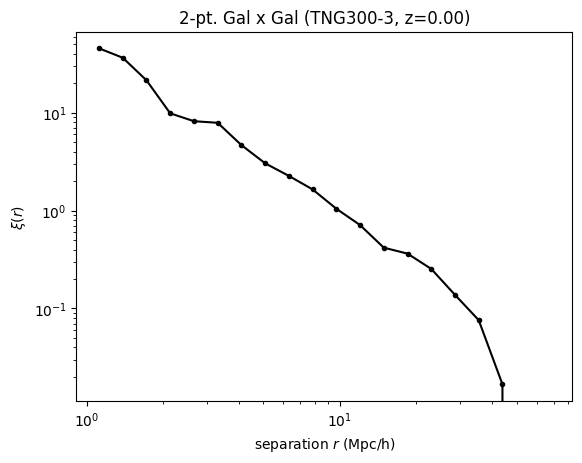

In [15]:
fig, ax = plt.subplots()

ax.plot(ravg, xi_galxgal, 'k.-')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'separation $r$ (Mpc/h)')
ax.set_ylabel(r'$\xi(r)$')
ax.set_title(f'2-pt. Gal x Gal ({sim.sim_tag})')

#### linear theory from Colossus

In [16]:
xi_lin = tools.linear_2pcf(z, ravg)

#### compare ratios

In [23]:
b_cross = xi_galxdm/xi_lin
b_auto = np.sqrt(xi_galxgal/xi_lin)

/tmp/ipykernel_2848073/4054483090.py:2: RuntimeWarning: invalid value encountered in sqrt
  b_auto = np.sqrt(xi_galxgal/xi_lin)


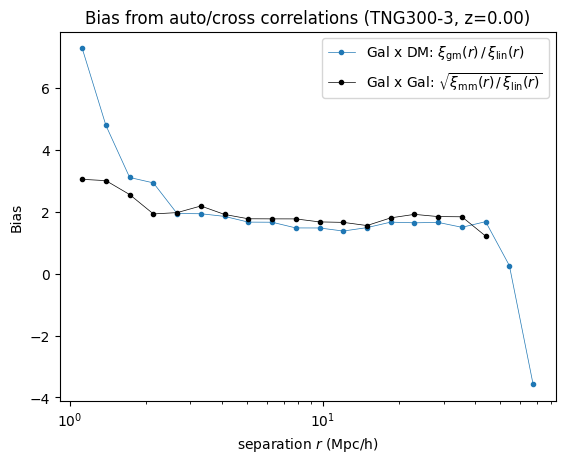

In [30]:
fig, ax = plt.subplots()

ax.plot(ravg, b_cross, marker='.', lw=0.5, label=r'Gal x DM: $\xi_\mathrm{gm}(r)\,/\,\xi_\mathrm{lin}(r)$')
ax.plot(ravg, b_auto, marker='.', lw=0.5, color='k', label=r'Gal x Gal: $\sqrt{\xi_\mathrm{mm}(r)\,/\,\xi_\mathrm{lin}(r)}$')

ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_xlabel(r'separation $r$ (Mpc/h)')
ax.set_ylabel(r'Bias')
ax.set_title(f'Bias from auto/cross correlations ({sim.sim_tag})')
ax.legend()